<a href="https://colab.research.google.com/github/fazalpge/Tensor-flow/blob/main/code_yolox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model does not provide scores (confidence values) in output.


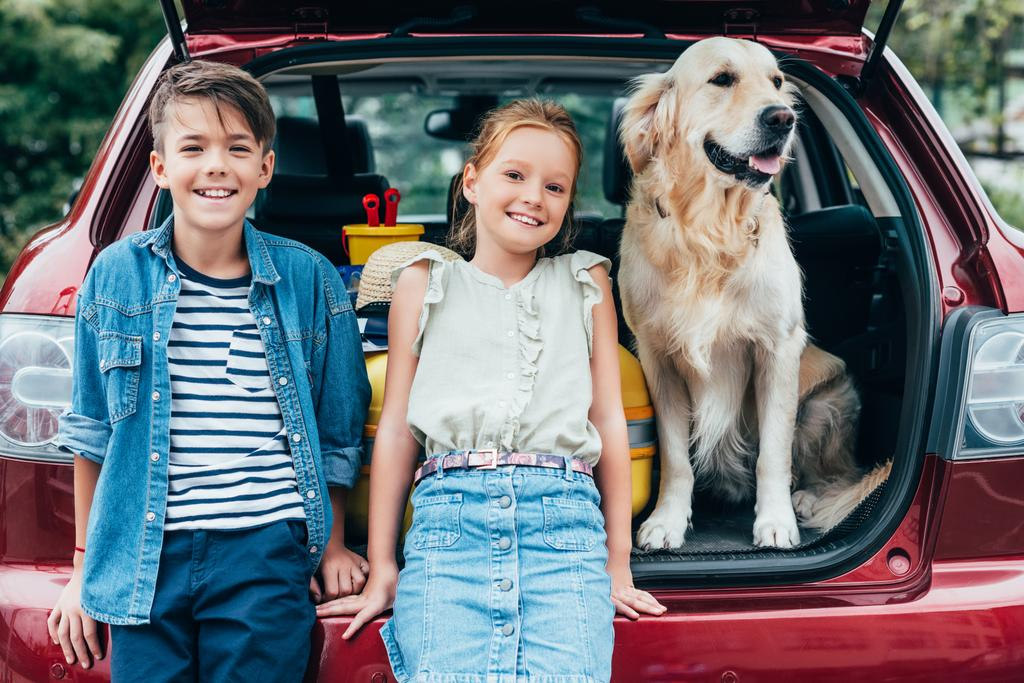

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/yolox_s.tflite")
interpreter.allocate_tensors()

# Get input and output details (assuming a single input and output tensor)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define a function to preprocess image for TFLite model (adjust based on model requirements)
def preprocess_image(image):
    # Check if image is empty
    if image.size == 0:
        raise ValueError("Empty image provided for preprocessing.")

    # Get expected dimensions (replace with your actual values)
    expected_width = 640
    expected_height = 640

    try:
        # Resize image
        image = cv2.resize(image, (expected_width, expected_height))
    except Exception as e:
        print(f"Error resizing image: {e}")
        # Handle error (e.g., use default size, log the error)

    # Normalize pixel values (typical range: 0-1 or -1 to 1)
    image = image.astype(np.float32) / 255.0

    # Add batch dimension if expected shape has length 4
    expected_shape = interpreter.get_input_details()[0]['shape']
    if len(expected_shape) == 4:
        image = np.expand_dims(image, axis=0)

    return image


# Function to perform object detection using the TFLite model
def detect_objects(image):
    preprocessed_image = preprocess_image(image)
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
    interpreter.invoke()

    # Get output tensors based on model (adjust based on output structure)
    output_details = interpreter.get_output_details()
    boxes = interpreter.get_tensor(output_details[0]['index'])

    scores = None  # Default value if scores are not available
    classes = None  # Default value if classes are not available

    # Check if scores and/or classes are present in output details
    # (You might need to modify the tensor names based on your model)
    for detail in output_details:
        if detail['name'] == 'scores' or detail['name'] == 'confidences':
            scores = interpreter.get_tensor(detail['index'])
        elif detail['name'] == 'classes' or detail['name'] == 'labels':
            classes = interpreter.get_tensor(detail['index'])

    # Process detections (apply appropriate threshold, NMS, etc.)
    # Example: Assuming you have a threshold for confidence score (if scores exist)
    if scores is not None:
        threshold = 0.5
        detections = []
        for i in range(boxes.shape[0]):
            if scores[i] > threshold:
                ymin, xmin, ymax, xmax = boxes[i]
                class_id = int(classes[i]) if classes is not None else None  # Handle class output if available
                detections.append((ymin, xmin, ymax, xmax, scores[i], class_id))
    else:
        # Handle case where scores are not available (e.g., print a message)
        print("Model does not provide scores (confidence values) in output.")
        detections = []  # Empty list to avoid further errors

    return detections

# Load your image
try:
  image = cv2.imread("/content/img.jpeg")
except FileNotFoundError:
  print("Image file not found!")
  exit()

# Call preprocess_image with error handling
try:
  preprocessed_image = preprocess_image(image)
  # ... rest of your object detection logic
except ValueError as e:
  print(f"Error preprocessing image: {e}")
  # Handle error (e.g., display a message to the user)

# Detect objects
detections = detect_objects(image)

# Draw bounding boxes and labels (if applicable)
for ymin, xmin, ymax, xmax, score, class_id in detections:
  cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
  if class_id is not None:
    # Load class labels from a file (optional)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus",
                   "train", "truck", "boat", "traffic light", "fire hydrant",
                   "stop sign", "parking meter", "bench", "bird", "cat", "dog",
                   "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
                   "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
                   "skis", "snowboard", "sports ball", "kite", "baseball bat",
                   "baseball glove", "skateboard", "surfboard", "tennis racket",
                   "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
                   "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
                   "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant",
                   "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
                   "remote", "keyboard", "cell phone", "microwave", "oven", "toaster",
                   "sink", "refrigerator", "book", "clock", "vase", "scissors",
                   "teddy bear", "hair drier", "toothbrush"]  # Replace with your actual class labels
    label_text = labels[class_id]
    cv2.putText(image, label_text, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2)

# Display the image with detections (using cv2_imshow for Colab)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

# Optional: Wait for a key press before closing the window
# cv2.waitKey(0)
# cv2.destroyAllWindows()
